In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [3]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'sketch_tokens'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                  n_from_end=1, root=root, verbose=True);
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/sketch_tokens/Nov-11-2021_1659_27/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'corr_each_feature', 'min_pct_var', 'max_pc_to_retain', 'use_pca_st_feats', 'use_lda_st_feats', 'lda_discrim_type'])
subject = 1
volume_space = 1
fitting_type = sketch_tokens
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (15000,)
voxel_index: len 1
voxel_roi: len 4
voxel_ncsnr: shape (699192,)
aperture = 1.0
aperture_rf_range = 1.1
which_prf_grid = 5
models: shape (1456, 3)
best_losses: shape 

In [4]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [9]:
port=33333
summary_plots.plot_summary_pycortex(out=out, subject=subject, fitting_type=fitting_type, \
                                port=port, roi_def=roi_def)

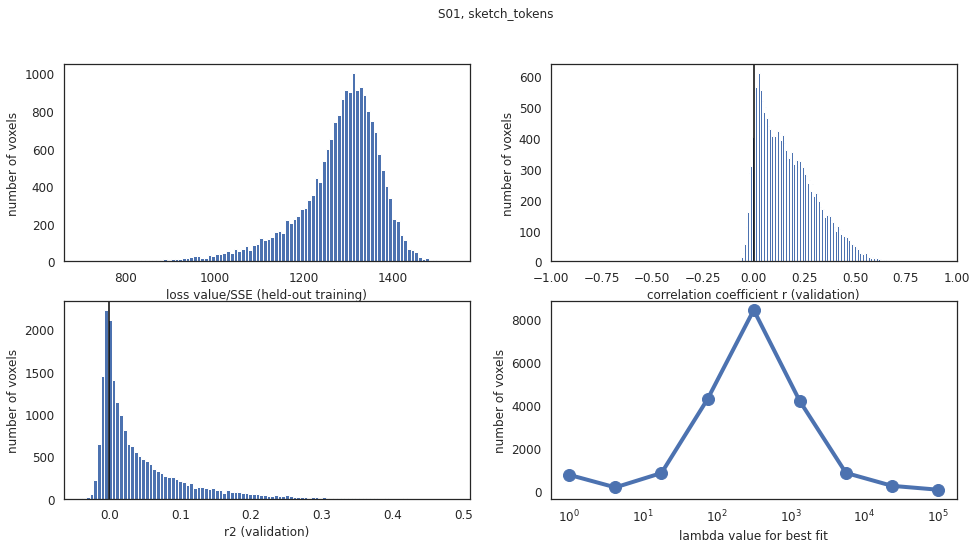

In [7]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

In [6]:
# plot_utils.plot_fit_summary_volume_space(subject, fitting_type,out, fig_save_folder)

In [7]:
summary_plots.plot_summary_pycortex(subject, fitting_type, out, roi_def=roi_def, port=33333)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


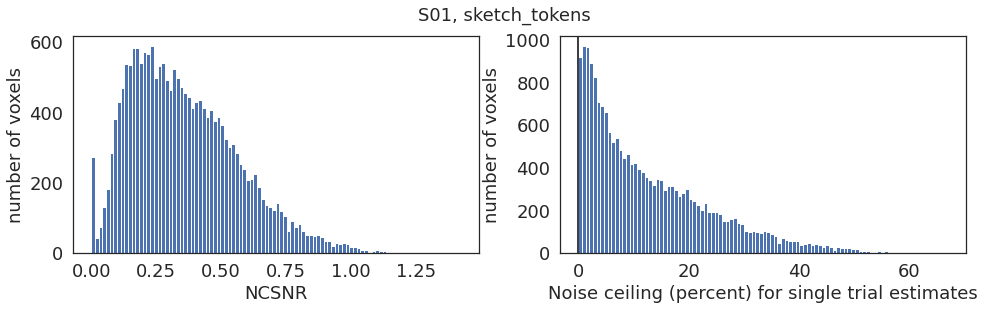

In [15]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

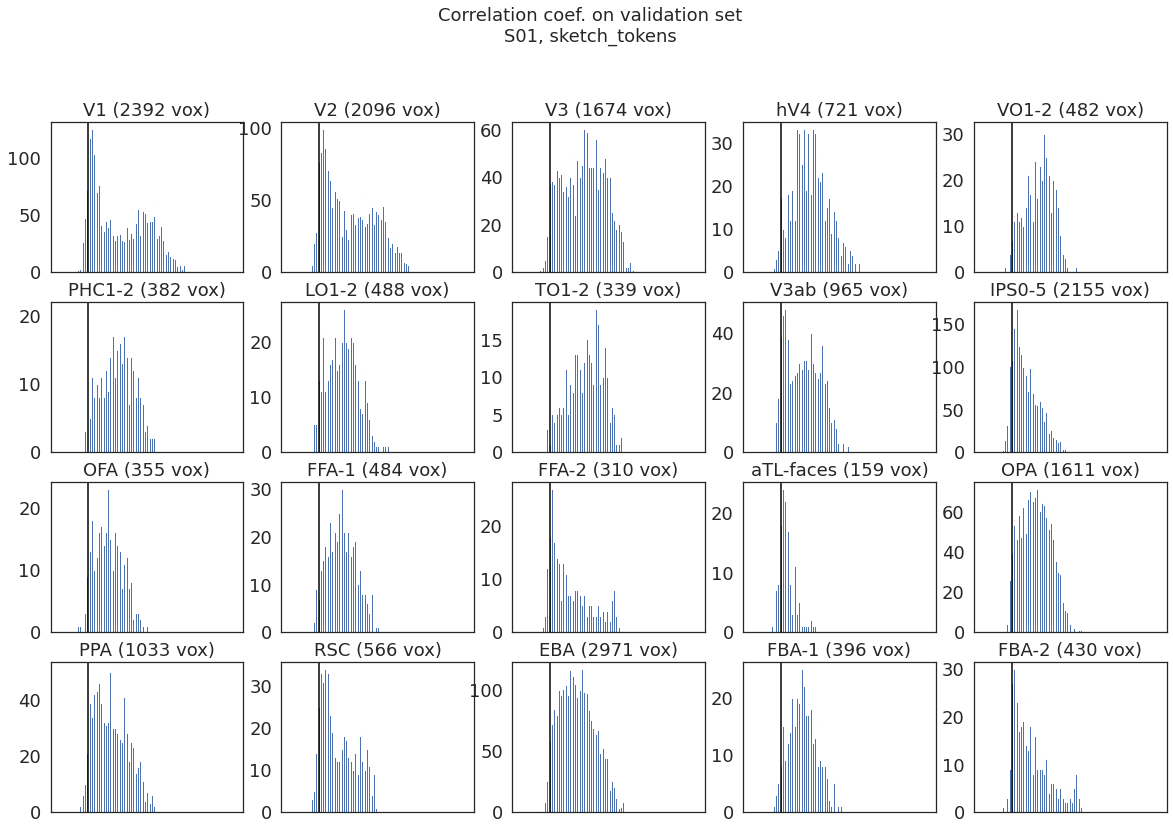

In [8]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_cc_each_roi(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, \
                               fig_save_folder=fig_save_folder)

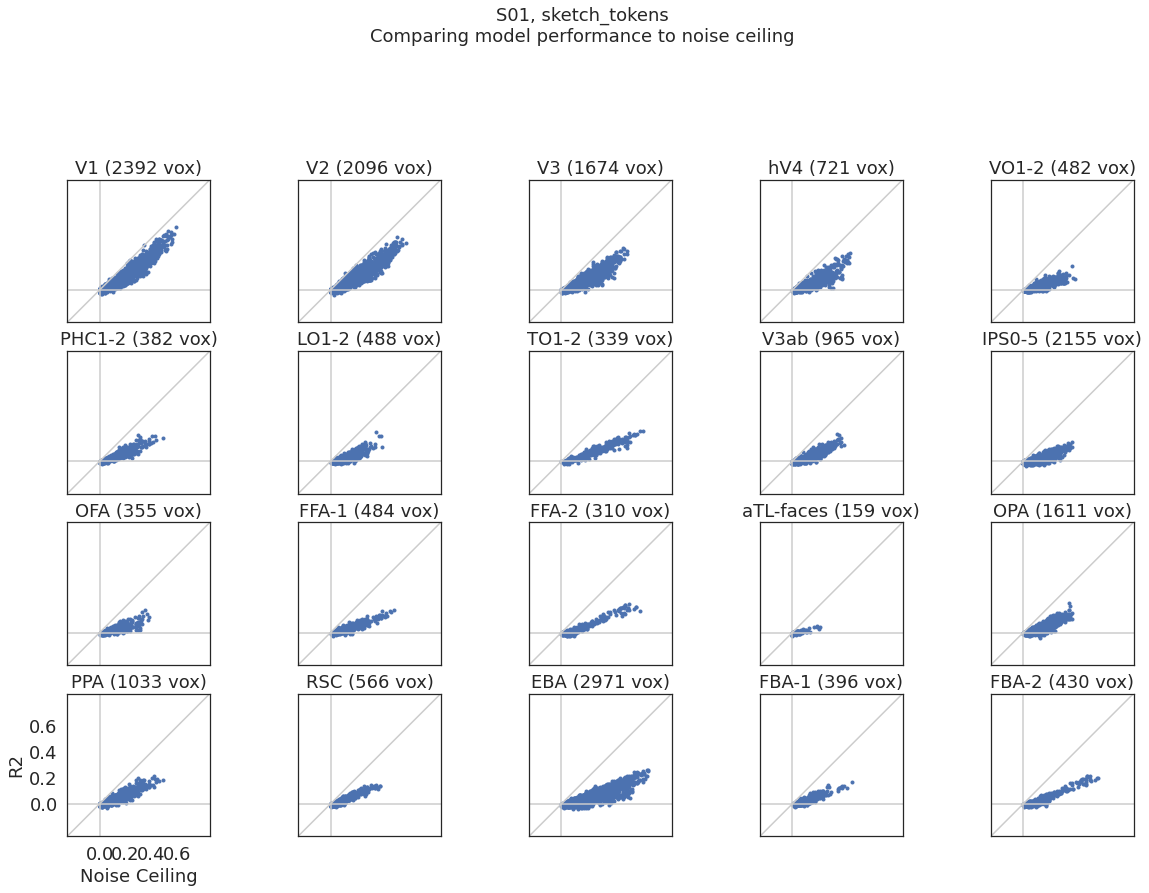

In [9]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_r2_vs_nc(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, \
                            axlims = [-0.25, 0.85], fig_save_folder=fig_save_folder, fig_size=(20,24))

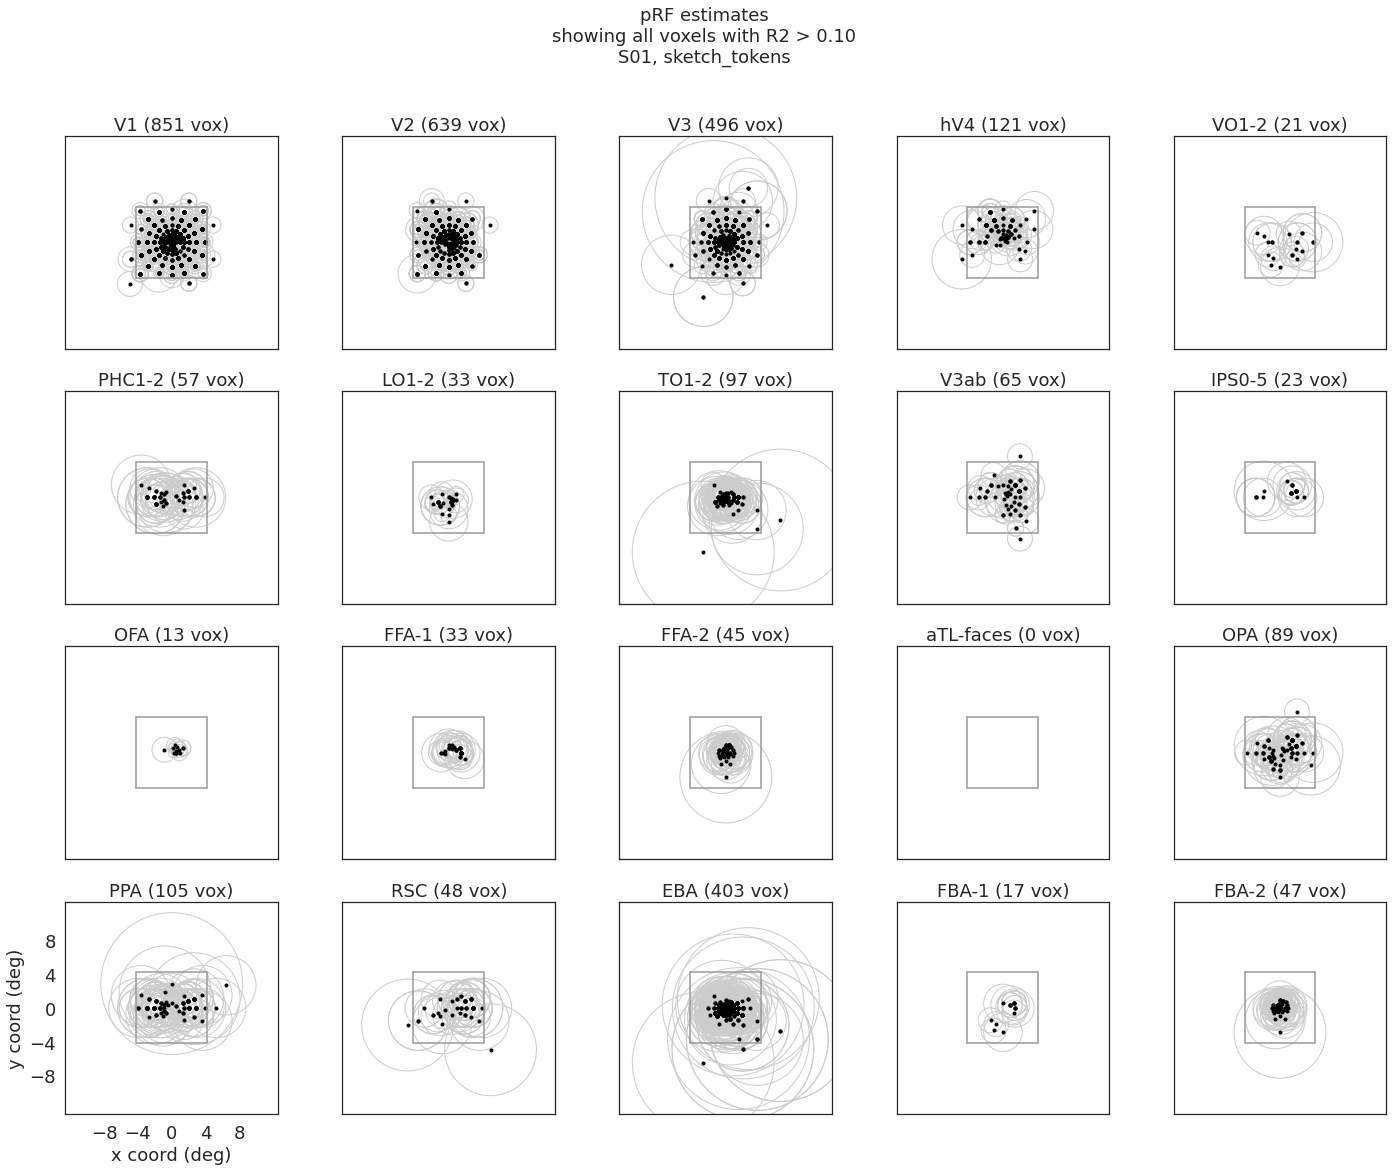

In [10]:
plot_utils.set_all_font_sizes(fs = 18)
plot_prf_params.plot_spatial_rf_circles(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds,\
                                     r2_cutoff = 0.10, fig_save_folder=fig_save_folder)

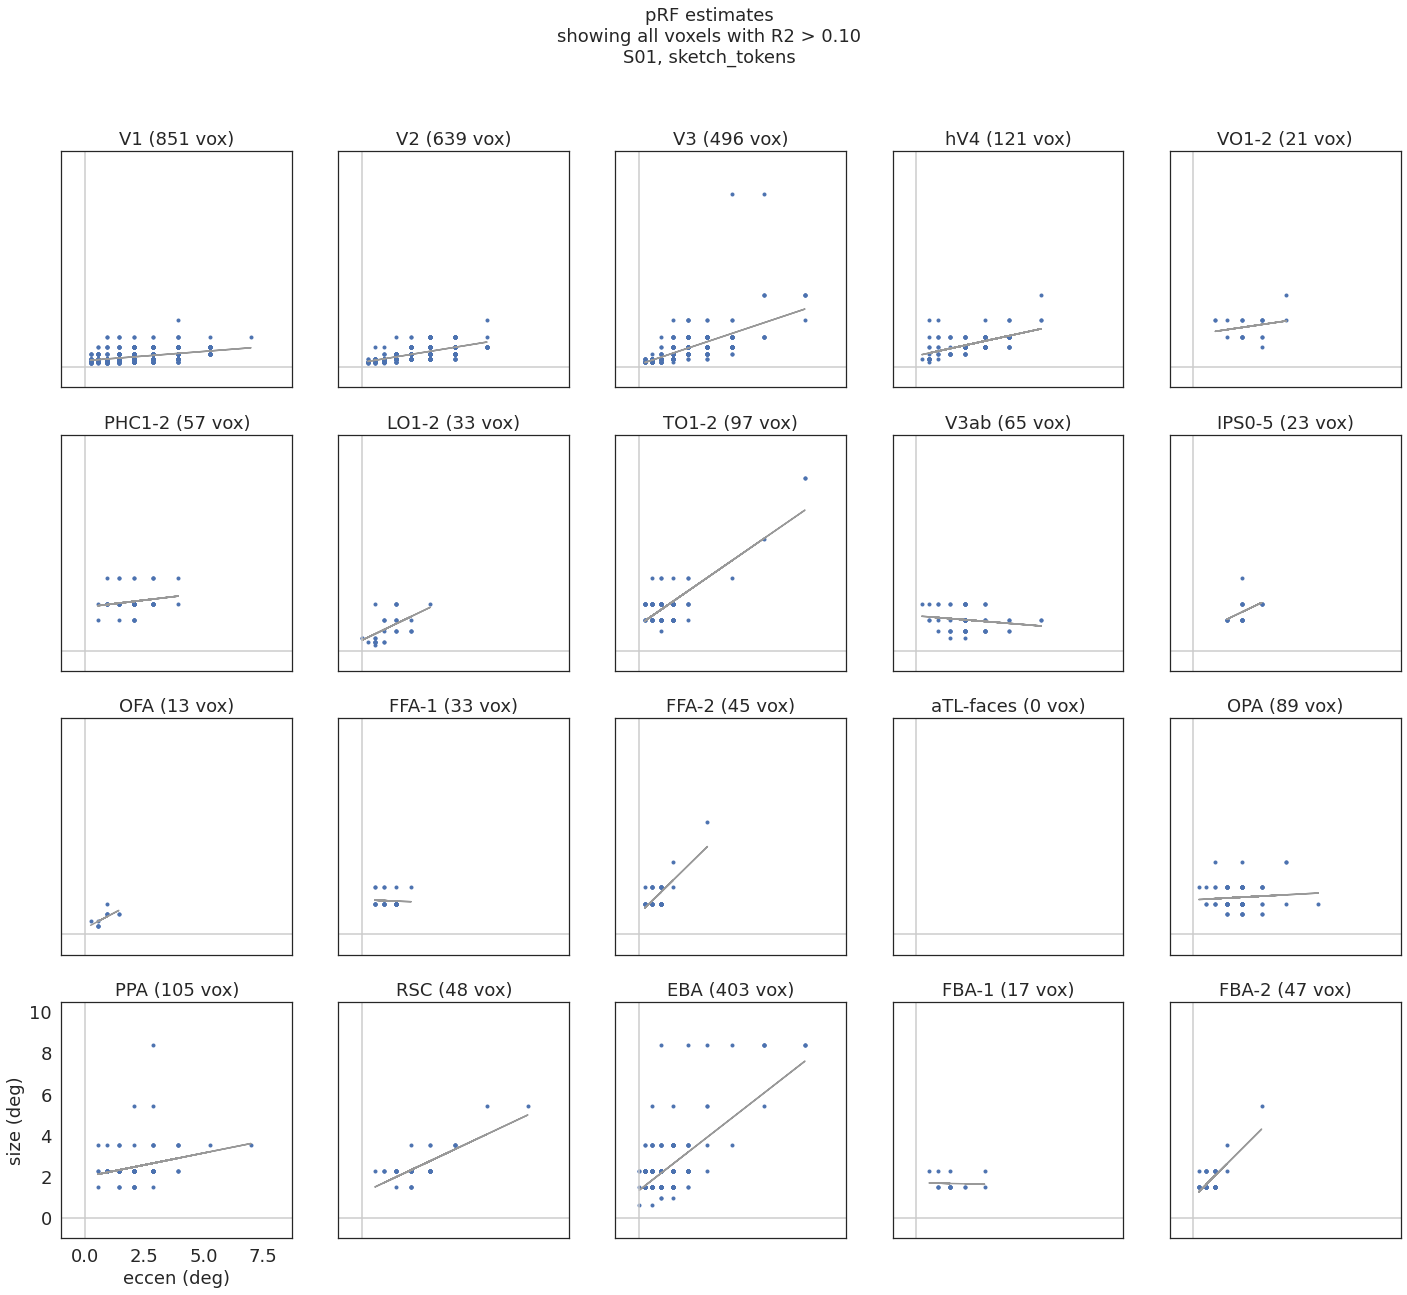

In [11]:
plot_utils.set_all_font_sizes(fs = 18)
plot_prf_params.plot_size_vs_eccen(subject, fitting_type, out, roi_def=roi_def, skip_inds=skip_inds, \
                                   r2_cutoff=0.10, fig_save_folder=fig_save_folder)

In [8]:
feature_weights = out['best_params'][1][:,:,0]
feature_corr = out['corr_each_feature']

In [6]:
best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out);
np.max(best_size_deg)

8.4

In [15]:
# Make plots in pycortex for variance partitioning analysis

import cortex

port=33333

vox2plot = out['val_r2'][:,0]>0

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out);
names = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [10, 360, 8]


maps += [np.sqrt(out['val_r2'][:,0])]
names += ['sketch tokens model R2 (sqrt)']
cmaps += ['PuBu']
mins += [0]
maxes += [0.6]

discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
maps += [discrim_each_axis[:,dd] for dd in range(n_sem_axes)]
names += ['dprime: %s'%dd for dd in discrim_type_list]
cmaps += ['RdBu' for dd in range(n_sem_axes)]
mins += [-1.5 for dd in range(n_sem_axes)]
maxes += [1.5 for dd in range(n_sem_axes)]

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


KeyError: 'discrim_each_axis'

In [12]:
nret = len(ret_names)
nface = len(face_names)
nplace = len(place_names)
nbody = len(body_names)    
n_rois = len(ret_names) + len(face_names) + len(place_names) + len(body_names)
roi_names = ret_names+face_names+place_names+body_names

is_ret = np.arange(0, n_rois)<nret
is_face = (np.arange(0, n_rois)>=nret) & (np.arange(0, n_rois)<nret+nface)
is_place = (np.arange(0, n_rois)>=nret+nface) & (np.arange(0, n_rois)<nret+nface+nplace)
is_body = np.arange(0, n_rois)>=nret+nface+nplace


In [13]:
discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
mean_discrim_each_roi = np.zeros((n_rois, n_sem_axes))

for rr in range(n_rois):
    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
        mean_discrim_each_roi[rr,:] = np.mean(np.abs(discrim_each_axis[inds_this_roi,:]), axis=0)
    else:
        mean_discrim_each_roi[rr,:] = np.nan


for aa, discrim_type in enumerate(discrim_type_list):
    plt.figure(figsize=(12,4));
    inds2use = ~np.isin(np.arange(n_rois), skip_inds)
#     inds2use = ~np.isnan(dprime_vals[:,aa])
    n_rois_plot = np.sum(inds2use)
    plt.bar(np.arange(n_rois_plot),mean_discrim_each_roi[inds2use,aa])
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[inds2use], rotation=90);
    plt.ylabel('d-prime')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
#     plt.ylim([0,2])

KeyError: 'discrim_each_axis'

In [14]:
# load info about actual sketch tokens features

from scipy.io import loadmat
from utils import stats_utils
cluster_fn = os.path.join('/user_data/mmhender/toolboxes/SketchTokens/', 'clusters.mat')
clust = loadmat(cluster_fn)
feature_ims = clust['clusters']['clusters'][0][0]

# Measuring approximate orientation of each sketch token feature, 
# based on simple filter in FFT space

orient_meas = np.arange(0,180,5)
n_features = feature_ims.shape[2]
orient_activs = np.zeros((n_features, len(orient_meas)))

n_pix = feature_ims.shape[0]
xx,yy = np.meshgrid(np.linspace(-1,1,n_pix), np.linspace(-1,1,n_pix))
rr = np.sqrt((xx)**2 + (yy)**2)
angle = np.arccos(xx/rr)
angle[yy>0] = np.pi - angle[yy>0]
angle = np.mod(angle+np.pi/2, np.pi)
angle[np.isnan(angle)] = 0
angle = angle/np.pi*180

vm_conc = 10 # control precision of orientation filter
orient_filters = np.array([stats_utils.von_mises_deg(angle,mu=oo,k=vm_conc,normalize=True) \
                           for oo in orient_meas])
for ff in range(n_features):
    im_fft = np.fft.fftshift(np.fft.fft2(feature_ims[:,:,ff]))   
    orient_activs[ff,:] = np.tensordot(orient_filters, np.abs(im_fft))
    
max_orient = orient_meas[np.argmax(orient_activs, axis=1)]
max_orient_activ = np.max(orient_activs, axis=1)


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in remainder


In [46]:
best_feature = np.argmax(out['corr_each_feature'], axis=1);
best_feature_orient = max_orient[best_feature]
best_feature_orient_activ = max_orient_activ[best_feature]

In [ ]:
# load actual images
image_data = get_image_data(subject, random_images)
image_data = image_uncolorize_fn(image_data)

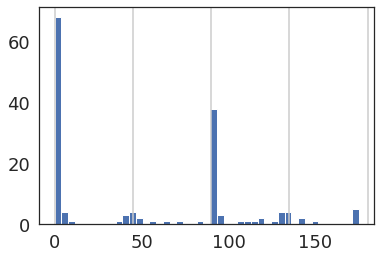

In [80]:
plt.figure();
plt.hist(max_orient,45);
for ii in np.arange(0,181,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8])

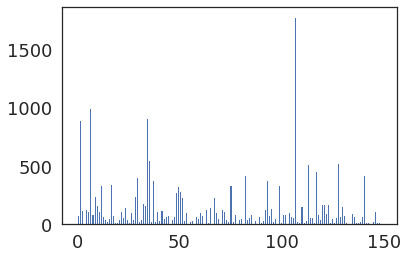

In [75]:
plt.figure();
plt.hist(best_feature,150);

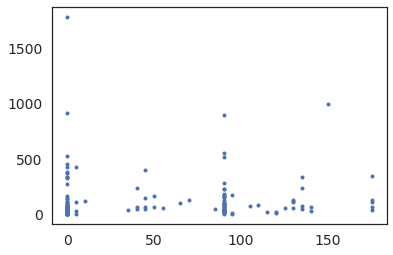

In [33]:
neach = [np.sum(best_feature==ff) for ff in range(150)]
plt.figure();
plt.plot(max_orient,neach,'.')

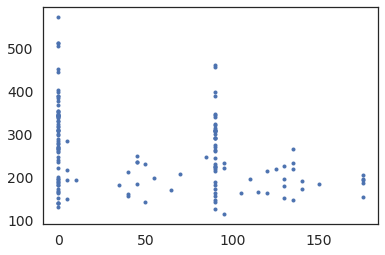

In [45]:
neach = [np.sum(best_feature==ff) for ff in range(150)]
plt.figure();
plt.plot(max_orient,max_orient_activ,'.')

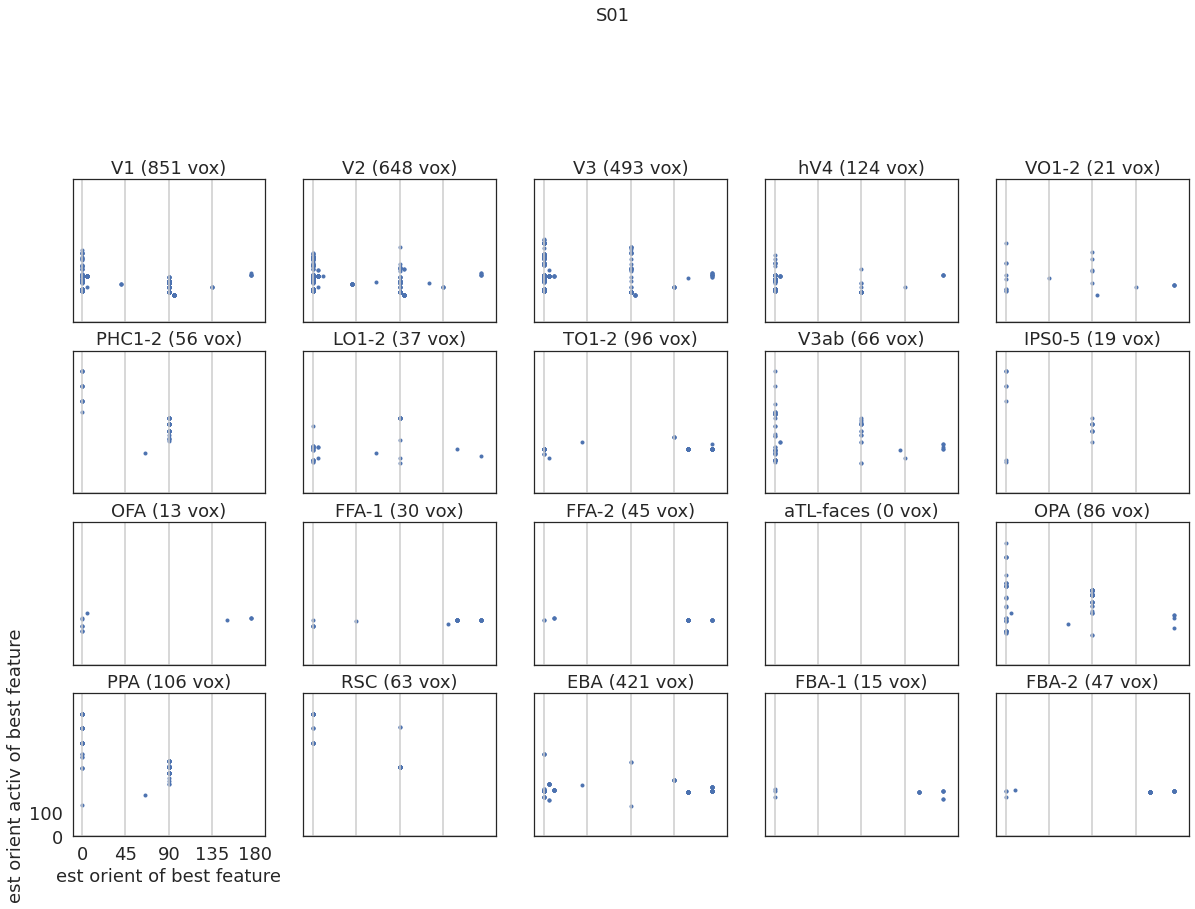

In [48]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.10
val1 = best_feature_orient
val2 = best_feature_orient_activ
dat = np.concatenate((val1[:,np.newaxis],val2[:,np.newaxis]), axis=1)

inds2use = out['val_r2'][:,0]>r2_cutoff

sp = plot_utils.scatter_plot(color=None, xlabel='est orient of best feature', \
                             ylabel='est orient activ of best feature', \
                             xlims=[-10,190], ylims=[0,600], \
                  xticks=np.arange(0,181,45), yticks=([0,100]),\
                  show_diagonal=False, show_axes=True, square=False);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out,\
                    suptitle='S%02d'%(subject), \
                   label_just_corner=True, figsize=(20,24), roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
axes = plt.gcf().get_axes();
for ax in axes:
    for ii in np.arange(45,136,45):
        ax.axvline(ii, color=[0.8, 0.8, 0.8])
#     print(ax)
#     plt.axvline(90, figure=ax);

13641
hV4


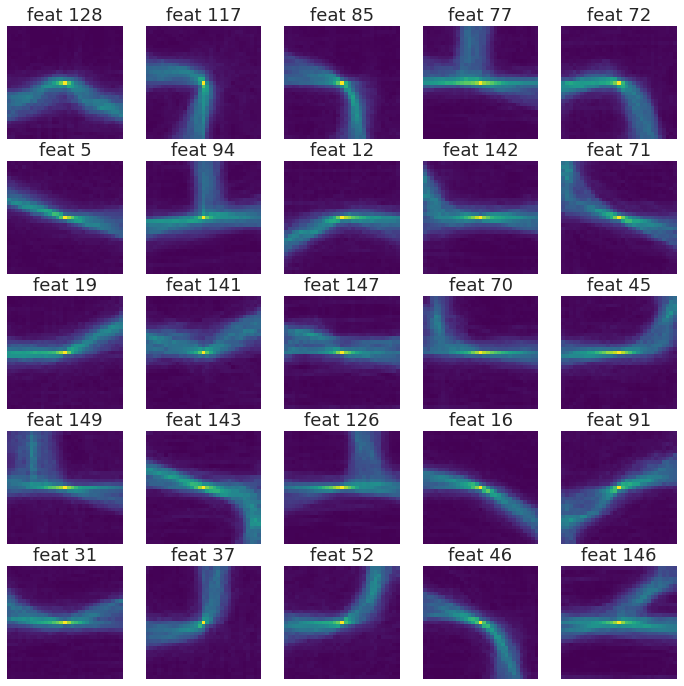

In [82]:
rind = 3
n = 0
this_roi = np.where(retlabs==rind)[0]
vind = np.flip(np.argsort(out['val_r2'][retlabs==rind,0]))[n]
vind = this_roi[vind]
vind = 13641
print(vind)
name = np.array(ret_names)[int(retlabs[vind])] 
print(name)

best_feature_inds = np.flip(np.argsort(out['corr_each_feature'][vind,:]))[0:25]
# wts = out['best_params'][1][vind,:,0]
# best_feature_inds = np.flip(np.argsort(wts))[0:25]

plt.figure(figsize=(12,12));
for ii, im in enumerate(best_feature_inds):
    plt.subplot(5,5,ii+1)
    plt.pcolormesh(feature_ims[:,:,im])
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.title('feat %d'%im)
#     plt.title('w=%.2f'%(wts[im]))
#     plt.title('%d deg'%(max_orient[im]))
#     plt.title('%d, corr=%.2f'%(im,out['corr_each_feature'][vind,im]))

In [88]:
import pandas as pd
rankfn = os.path.join(default_paths.stim_root,'S%d_ranked_images.csv'%subject)
ranked_images = pd.read_csv(rankfn, index_col=0)

In [89]:
ranked_images

,voxel 0,voxel 1,voxel 2,voxel 3,voxel 4,voxel 5,voxel 6,voxel 7,voxel 8,voxel 9,...,voxel 19728,voxel 19729,voxel 19730,voxel 19731,voxel 19732,voxel 19733,voxel 19734,voxel 19735,voxel 19736,voxel 19737
0,2529,2083,2054,7918,7514,4158,4659,630,2451,1056,...,4719,6708,6136,8493,3917,2717,3598,2696,2409,2887
1,7918,2843,7795,7234,2083,885,7234,6302,2347,6800,...,6708,7234,4068,2696,6708,5242,3676,6708,1008,4637
2,3997,7874,9933,2503,7795,2529,2617,3922,7769,6590,...,2102,6965,9329,9675,2715,3716,34,3676,4480,3766
3,3887,3523,3136,1765,754,7402,1917,8964,4889,879,...,5242,5242,993,7368,8906,2020,2761,7565,9900,4791
4,3915,2796,4995,6104,7607,4768,6661,5242,5540,5510,...,6965,3676,6708,2532,7607,9329,8798,5242,7966,9254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9394,8831,5688,2116,6394,7261,6870,7446,8357,2962,...,8969,1246,2232,6705,5662,6287,3672,1289,9672,5640
9996,225,5744,4927,1013,2486,225,9847,205,2674,3741,...,6401,602,1246,4032,1633,351,6953,9013,4228,4495
9997,7082,6532,2550,4275,7144,9736,7029,7648,9673,9605,...,5235,5034,4241,3795,1317,5375,7661,3087,1879,9672
9998,9847,8129,4461,8089,4538,3225,406,4834,319,9792,...,7022,246,5375,791,987,5052,1889,8784,2042,2042


In [71]:
max_orient

array([  0,  90,  10,   0,  70, 175, 150, 110,  40,  50, 130, 135,   0,
        85,  90,  55, 175,   0, 120,   0,  35,   0, 125,  45, 135,  95,
        65,   0, 135,  45,   0,   0,  90,   0,   0,  90,  90,   0,   0,
         5,  90, 130,  45,  50,   0,   0, 175,  90,   0,   0,  90,  90,
         0,  90,   0,  90,  90,   0,  45,  90,  90, 105,   0,  90,   0,
         0,   0,  90,  90,  90,   0, 175,   0,   0, 115,   0,  90,   0,
         0,  90,   0,   0,   5,  40,   0,   0,   0,  90,   0,   0,  90,
         5, 130,   0,   0,   0,   0,   0,   0,   0,   0,  90,   0,  90,
        90, 140,   0,   0,  90, 120,  90,   0,   0,  90, 175,   0,   0,
         0,  90,  90,  90,  95,  90,  90,   0,  90,   0, 130,   0,  40,
        90, 135,   0,   0,   5,   0,  90,   0,   0, 140,  90,   0,   0,
         0,  95,  90,   0,   0,   0,   0])

In [65]:
wts.shape

(150,)

In [57]:
out['corr_each_feature'][vind,best_feature_inds]

array([0.89068037, 0.88295093, 0.88280922, 0.8799777 , 0.8797164 ,
       0.87875525, 0.87470188, 0.86375609, 0.86086617, 0.8596054 ,
       0.85777787, 0.85544965, 0.85478825, 0.85424396, 0.85424169,
       0.85062192, 0.84968693, 0.84886328, 0.84783617, 0.84771129,
       0.84598627, 0.84297532, 0.84268764, 0.84021385, 0.83494111])

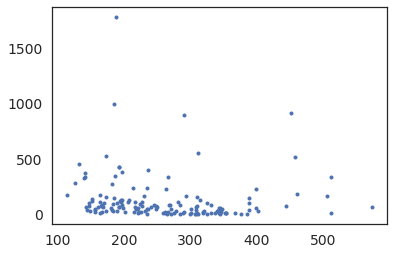

In [44]:
neach = [np.sum(best_feature==ff) for ff in range(150)]
plt.figure();
plt.plot(max_orient_activ,neach,'.')

In [41]:
np.array(neach)[ims2plot]

array([1783,  999,  916,  899,  554,  524,  520,  456,  428,  425,  405,
        384,  378,  345,  342,  338,  335,  333,  287,  274,  242,  241,
        235,  233,  183])

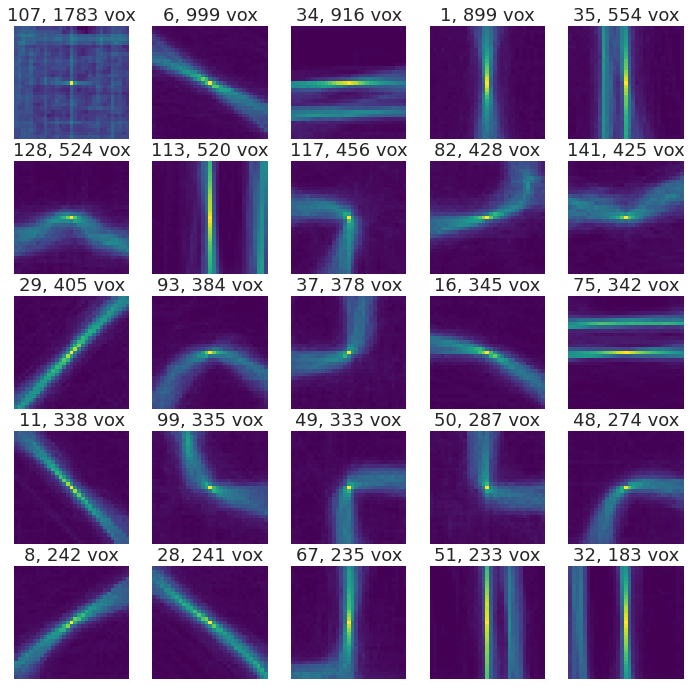

In [76]:
neach = [np.sum(best_feature==ff) for ff in range(150)]
ims2plot = np.flip(np.argsort(neach))[0:25]
plt.figure(figsize=(12,12));
for ii, im in enumerate(ims2plot):
    plt.subplot(5,5,ii+1)
    plt.pcolormesh(feature_ims[:,:,im])
    plt.gca().invert_yaxis()
    plt.axis('off')
#     plt.axis('square')
    plt.title('%d, %d vox'%(im,neach[im]))

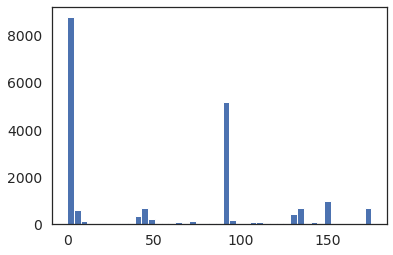

In [27]:
plt.figure();
plt.hist(best_feature_orient, 45);